In [2]:

import sys
sys.path.append("..")


import pandas as pd, numpy as np
from _settings import WORKSPACE
import os
events = pd.read_csv(os.path.join(WORKSPACE, 'data', 'mimic', 'chartevents.csv'))
pats = pd.read_csv(os.path.join(WORKSPACE, 'data', 'mimic', 'patients.csv')).set_index('subject_id')
#pats
#events
pats.head()

,gender,dob,dod,dod_hosp,dod_ssn,first_admit
subject_id,,,,,,
6749,F,2033-02-26 00:00:00,2112-08-26 00:00:00,2112-08-26 00:00:00,2112-08-26 00:00:00,2112-02-04 19:09:00.000000
42733,M,2075-11-11 00:00:00,NaN,NaN,NaN,2143-07-19 16:58:00.000000
88095,F,2098-11-18 00:00:00,NaN,NaN,NaN,2141-05-22 01:11:00.000000
46335,M,2030-02-22 00:00:00,2102-01-17 00:00:00,NaN,2102-01-17 00:00:00,2101-07-17 15:08:00.000000
9798,M,2038-04-22 00:00:00,NaN,NaN,NaN,2110-03-16 04:18:00.000000


In [3]:
mapping = pd.read_csv(os.path.join(WORKSPACE, 'data', 'mimic', 'mappings.csv'))
mapping = mapping[mapping['Name']!='FiO2'] #FiO2 is not necessary
summ_cols = ['Bilirubin', 'Creatinine', 'Hematocrit', 'Hemoglobin', 'Platelet', 'Potassium', 'WBC'] 
mean_cols = ['Diastolic blood pressure', 'Glucose', 'Mean blood pressure', 'SpO2', 'Systolic blood pressure', 'Temperature', 'Weight']
mean_cols += ['Heart Rate', 'Respiratory Rate']
assert len(pd.Index(mapping['Name'].unique()).difference(pd.Index(summ_cols)).difference(pd.Index(mean_cols))) == 0

rev_mapping = mapping.set_index('itemid')
mapping = mapping.set_index(['Name', 'DBSOURCE']).astype(int)['itemid']
mapping

Name                      DBSOURCE  
Bilirubin                 carevue         1538
                          metavision    225690
Creatinine                carevue         1525
                          metavision    220615
Diastolic blood pressure  carevue         8368
                          metavision    220180
Glucose                   carevue          807
                          metavision    225664
Heart Rate                carevue          211
                          metavision    220045
Hematocrit                carevue          813
                          metavision    220545
Hemoglobin                carevue          814
                          metavision    220228
Mean blood pressure       carevue           52
                          metavision    220181
Platelet                  carevue          828
                          metavision    227457
Potassium                 carevue         1535
                          metavision    227442
Respiratory Rate       

## Sanity Check - the columns seem to be the same thing from the two sources

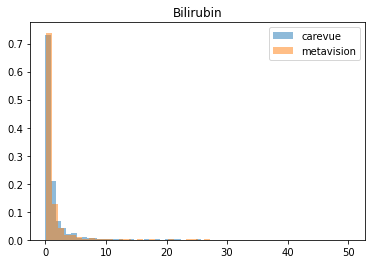

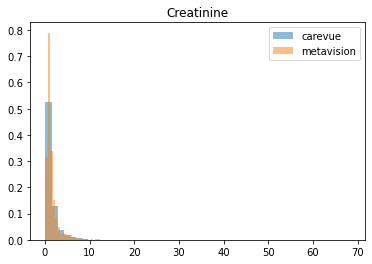

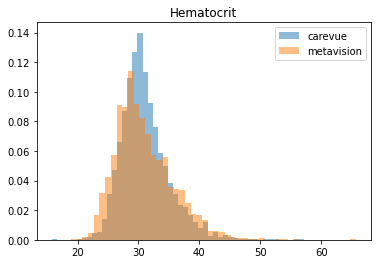

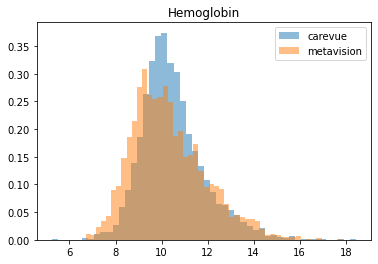

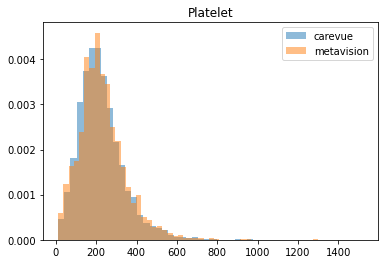

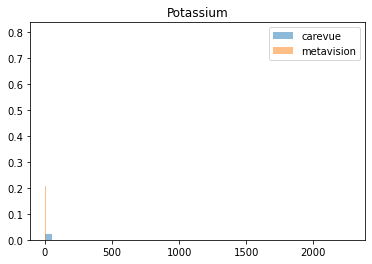

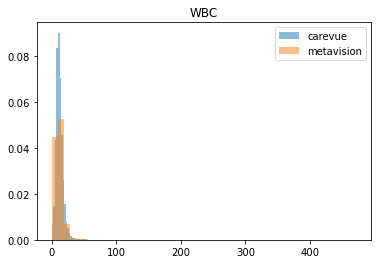

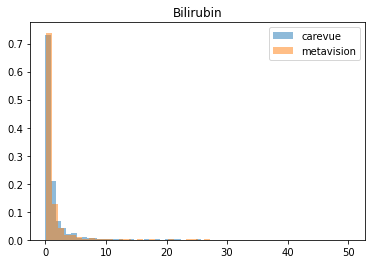

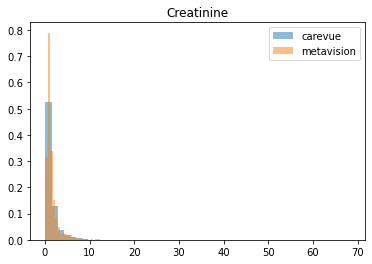

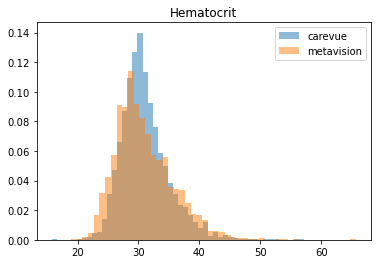

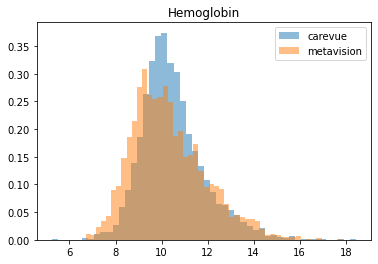

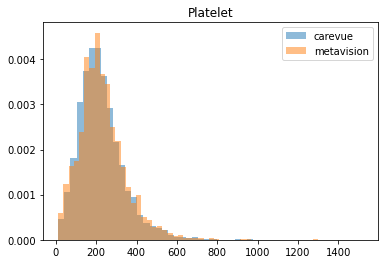

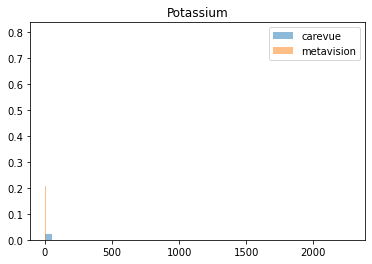

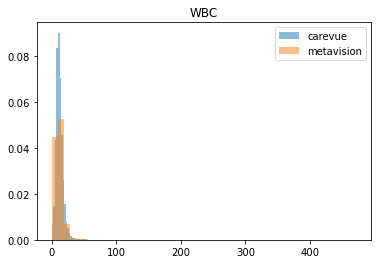

Bilirubin     1.130711
Creatinine    0.992161
Hematocrit    1.004847
Hemoglobin    1.016213
Platelet      0.976298
Potassium     1.167113
WBC           1.048965
dtype: float64

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

res = {}
for measure in summ_cols + summ_cols:
    cid = mapping.loc[measure, 'carevue']
    mid = mapping.loc[measure, 'metavision']
    cdf = events[events['itemid'] == cid]
    mdf = events[events['itemid'] == mid]
    cser = cdf.groupby('subject_id')['valuenum'].mean()
    mser = mdf.groupby('subject_id')['valuenum'].mean()
    res[measure] = cser.mean() / mser.mean()
    plt.hist(cser.values, label='carevue', bins=50, density =True, alpha=0.5)
    plt.hist(mser.values, label='metavision', bins=50, density = True, alpha=0.5)
    plt.legend()
    plt.title(measure)
    plt.show()
pd.Series(res)

In [5]:
def to_date(x):
    return x[:10]
    return pd.to_datetime(x.split(" ")[0])



events = events.merge(rev_mapping, right_index=True, left_on='itemid')
events['date'] = events['charttime'].map(to_date)
events = events.reindex(columns=['subject_id', 'date', 'Name', 'valuenum'])
tdf1_ = events[events['Name'].isin(set(summ_cols))]
tdf1_hi = pd.pivot_table(tdf1_, 'valuenum', ['subject_id', 'date'], 'Name', aggfunc=np.max).rename(columns=lambda x: f"{x} high")
tdf1_lo = pd.pivot_table(tdf1_, 'valuenum', ['subject_id', 'date'], 'Name', aggfunc=np.min).rename(columns=lambda x: f"{x} low")
tdf2 = pd.pivot_table(events[events['Name'].isin(set(mean_cols))], 'valuenum', ['subject_id', 'date'], 'Name', aggfunc=np.mean)
fdf = pd.concat([tdf2, tdf1_lo, tdf1_hi], axis=1).reset_index()
fdf.name = None

In [6]:


pats['dob'] = pats['dob'].map(to_date)
fdf = fdf.merge(pats.reindex(columns=['dob', 'first_admit']), left_on='subject_id', right_index=True)

In [7]:
fdf

,subject_id,date,Diastolic blood pressure,Glucose,Heart Rate,Mean blood pressure,Respiratory Rate,SpO2,Systolic blood pressure,Temperature,...,WBC low,Bilirubin high,Creatinine high,Hematocrit high,Hemoglobin high,Platelet high,Potassium high,WBC high,dob,first_admit
0,9,2149-11-09,82.481481,NaN,88.703704,101.518519,14.555556,97.629630,161.518519,96.425001,...,NaN,NaN,NaN,42.000000,NaN,NaN,2.9,NaN,2108-01-26,2149-11-09 13:06:00.000000
1,9,2149-11-10,78.187500,124.5,89.312500,98.593750,14.125000,98.764706,154.968750,98.950000,...,13.7,0.4,1.4,37.400002,13.0,261.0,3.0,14.4,2108-01-26,2149-11-09 13:06:00.000000
2,9,2149-11-11,72.470588,159.5,85.151515,93.264706,14.787879,98.088235,145.500000,97.133334,...,12.1,NaN,2.0,38.200001,12.9,221.0,3.5,12.1,2108-01-26,2149-11-09 13:06:00.000000
3,9,2149-11-12,76.282609,141.0,84.456522,97.760870,18.369565,95.510204,150.173913,98.016666,...,18.6,0.4,2.0,39.000000,13.1,261.0,3.6,18.6,2108-01-26,2149-11-09 13:06:00.000000
4,9,2149-11-13,75.846154,176.0,84.974359,93.210526,18.487179,96.536585,144.102564,98.033334,...,12.2,NaN,1.7,36.799999,12.8,308.0,3.8,18.4,2108-01-26,2149-11-09 13:06:00.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75241,79838,2100-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.8,NaN,0.6,24.600000,8.7,236.0,3.9,11.8,2039-06-12,2100-08-19 13:33:00.000000
75242,79838,2100-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.5,NaN,0.7,26.300000,9.1,306.0,3.6,8.5,2039-06-12,2100-08-19 13:33:00.000000
75245,94998,2128-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.8,NaN,0.8,30.900000,10.7,243.0,3.8,8.7,2063-04-14,2128-06-30 13:21:00.000000
75246,94998,2128-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.3,NaN,0.7,27.200000,9.6,239.0,3.5,7.3,2063-04-14,2128-06-30 13:21:00.000000


In [16]:


def _strs_to_age(date, dob, first_admit, remove_unknown=False):
    first_admit = to_date(first_admit)
    
    birthyear = int(dob[:4])
    if birthyear <= 1900: #first admit use -1 as a flag, as we need to adjust age in the next step
        if remove_unknown: return 300
        #https://mimic.mit.edu/docs/iii/about/time/ - <1900 means age >= 89 on the first admit
        age = int(date[:4]) - int(first_admit[:4]) + 89
        if int(date[5:].replace('-', '')) < int(first_admit[5:].replace('-', '')):
            age -= 1
        #age *= -1
    else:
        age = int(date[:4]) - birthyear
        if int(date[5:].replace('-', '')) < int(dob[5:].replace('-', '')):
            age -= 1
    return age


fdf['age'] = fdf.apply(lambda r: _strs_to_age(r['date'], r['dob'], r['first_admit']), axis=1)
fdf = fdf[fdf['age'] < 200]
fdf.age.value_counts().sort_index()

/tmp/ipykernel_6679/2826681994.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf['age'] = fdf.apply(lambda r: _strs_to_age(r['date'], r['dob'], r['first_admit']), axis=1)


16      9
17     46
18     84
19    103
20    239
     ... 
95     31
96     44
97     29
98     45
99      4
Name: age, Length: 84, dtype: int64

In [19]:
fdf.to_csv(os.path.join(WORKSPACE, 'data', 'mimic', 'processed.csv'), index=False)